## Introdution

Online content publishers often use catchy headlines for their
articles in order to attract users to their websites. These headlines, popularly known as clickbaits, exploit a user’s curiosity gap and lure them to click on links that often disappoint them. Existing methods for automatically detecting clickbaits rely on heavy feature engineering and domain knowledge. Here, my goal is to classification of clickbait news and non-clicbait news. I have fine-tune SOTA XLNet model for classification. I have used the amazing Transformers library by Hugging Face with pytorch. 

#### Dataset

The train1.csv collected from Abhijnan Chakraborty, Bhargavi Paranjape, Sourya Kakarla, and Niloy Ganguly. "Stop Clickbait: Detecting and Preventing Clickbaits in Online News Media”. In Proceedings of the 2016 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM), San Fransisco, US, August 2016.[GitHub](https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

It has two columns first one contains headlines and the second one has numerical labels of clickbait in which 1 represents that it is clickbait and 0 represents that it is non-clickbait headline. The dataset contains total 32000 rows of which 50% are clickbait and other 50% are non-clickbait.

The train2.csv collected from [Clickbait news detection dataset](https://www.kaggle.com/c/clickbait-news-detection/data) from the Kaggle InClass Prediction Competition. The dataset contains title and text  of the news and label. 

#### XLNet Model
XLNet is the latest and greatest model to emerge from the booming field of Natural Language Processing (NLP). The [XLNet paper](https://arxiv.org/pdf/1906.08237.pdf) combines recent advances in NLP with innovative choices in how the language modelling problem is approached. When trained on a very large NLP corpus, the model achieves state-of-the-art performance for the standard NLP tasks that comprise the GLUE benchmark. To learn more about the model see the [link.](https://towardsdatascience.com/what-is-xlnet-and-why-it-outperforms-bert-8d8fce710335) 

#### XLNet Fine-Tuning With PyTorch¶
I'll use XLNet with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task.

#### Reference
- [zihangdai/xlnet](https://github.com/zihangdai/xlnet),
- [Hugging Face](https://huggingface.co/transformers/model_doc/bert.html),
- [papers with code](https://paperswithcode.com/task/clickbait-detection)
- [Training Sentiment Model Using BERT-By Abhishek Thakur](https://www.youtube.com/watch?v=hinZO--TEk4&t=449s)
- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805),
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/),
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/),
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)\,
- [Huggingface Transformers](https://huggingface.co/transformers/),
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)

# Importing Packages

In [1]:
%%time
# https://www.kaggle.com/tunguz/melanoma-tsne-and-umap-embeddings-with-rapids/?

# INSTALL RAPIDS OFFLINE (FROM KAGGLE DATASET). TAKES 1 MINUTE :-)
import sys
!cp ../input/rapids/rapids.0.13.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.6"] + ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

rapids/
rapids/bin/
rapids/bin/msgunfmt
rapids/bin/pyvenv
rapids/bin/msgen
rapids/bin/djpeg
rapids/bin/gdaltindex
rapids/bin/gss-client
rapids/bin/pyvenv-3.7
rapids/bin/png-fix-itxt
rapids/bin/python3-config
rapids/bin/gif2rgb
rapids/bin/ncgen
rapids/bin/gdal-config
rapids/bin/PParse
rapids/bin/xzdec
rapids/bin/numba
rapids/bin/SAX2Count
rapids/bin/h5unjam
rapids/bin/glib-gettextize
rapids/bin/fc-list
rapids/bin/xzgrep
rapids/bin/giftool
rapids/bin/grpc_python_plugin
rapids/bin/k5srvutil
rapids/bin/gifbuild
rapids/bin/gflags_completions.sh
rapids/bin/uuclient
rapids/bin/gio-querymodules
rapids/bin/dask-ssh
rapids/bin/msguniq
rapids/bin/lz4c
rapids/bin/ncdump
rapids/bin/vacuumlo
rapids/bin/bzfgrep
rapids/bin/ngettext
rapids/bin/jupyter-kernel
rapids/bin/gdal_sieve.py
rapids/bin/pydoc3.7
rapids/bin/gdalsrsinfo
rapids/bin/hwloc-gather-cpuid
rapids/bin/lzdiff
rapids/bin/pg_receivewal
rapids/bin/rdjpgcom
rapids/bin/gnmanalyse
rapids/bin/jupyter-run
rapids/bin/ktutil
rapids/bin/invproj
rapid

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


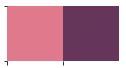

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
from contextlib import contextmanager

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Thanks to @andradaolteanu for color_nude
# Set Color Palettes for the notebook
colors_nude = ['#e0798c','#65365a']
sns.palplot(sns.color_palette(colors_nude))
# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

import transformers
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import warnings
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

## Configuration

In [3]:
class config:
    # maximum possible sequence length is 512.
    MAX_LEN = 128
    
    # refer to the table here https://github.com/google-research/bert to adjust batch size to seq length
    TRAIN_BATCH_SIZE = 36  
    VALID_BATCH_SIZE = 18
    SEED = 2020
    
    # number of epochs
    EPOCHS = 3
    # learning rate to tune xlnet
    LRATE = 2e-5 
    
    # wait for several backward steps, then one optimization step, this allows to use larger batch size
    # well explained here https://bit.ly/2MCMHUX
    ACCUM_STEPS = 2
    
    # warmup helps to tackle instability in the initial phase of training with large learning rates. 
    # During warmup, learning rate is gradually increased from 0 to LRATE.
    # WARMUP is a proportion of total weight updates for which warmup is done. By default, it's linear warmup
    WARMUP = 5e-2
    
    # File Paths
    MODEL_PATH = "model.bin"         
    TRAINING_FILE_1 = "../input/news-clickbait-dataset/train1.csv"
    TRAINING_FILE_2 = "../input/news-clickbait-dataset/train2.csv"
    
    # Loading xlnet tokenizer
    print('Loading XLNet tokenizer...')
    TOKENIZER = transformers.XLNetTokenizer.from_pretrained(
        "xlnet-base-cased", 
        do_lower_case=True
    )

Loading XLNet tokenizer...


## Helper Functions

In [4]:
# nice way to report running times
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [5]:
# make results fully reproducible
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Reading and Preparing the data

In [6]:
# Reading dataset
train1 = pd.read_csv(config.TRAINING_FILE_1)
display(train1.sample(n=8))
print('shape of data', train1.shape)
print(' ')
print(train1['clickbait'].value_counts())

headline  clickbait
7723   34 Hilarious Nicknames Chinese People Have Giv...          1
21824         Katrina raised gas prices higher than ever          0
26601  Montana judge frees Barry Beach pending homici...          0
21387  CBS blog criticizes stations' coverage of Tigg...          0
26565  Governor of Illinois arrested on suspicion of ...          0
13924  For Everyone Who Thinks Hermione Should Have E...          1
5230   It's Finally Winter In Canada And People Aren'...          1
31515                 Gunmen abduct aid workers in Sudan          0

shape of data (32000, 2)
 
0    16001
1    15999
Name: clickbait, dtype: int64


In [7]:
# Reading dataset
train2 = pd.read_csv(config.TRAINING_FILE_2)
display(train2.sample(n=8))
print('shape of data', train2.shape)
print(' ')
print(train2['label'].value_counts())

label                                              title
12035       news  Golden Globes Ratings Up As A Political Meryl ...
4348        news           Hank Williams: The Hillbilly Shakespeare
2970        news       What will immigration look like post-Brexit?
3101        news           Golf Balls in Hash Browns Lead to Recall
9792        news  Sushma Swaraj Seeks Report From Embassy In Dub...
9007        news  Activists spend 6 hours suspended from Shell s...
6571   clickbait  Rosie O’Donnell Wants to Play Steve Bannon on ...
391         news  O'Reilly on 'Watters' World': The Far Left 'Ju...

shape of data (21029, 2)
 
news         16738
clickbait     4291
Name: label, dtype: int64


In [8]:
# rename the column clickbait to label and title to headline
train1.rename(columns={'clickbait': 'label'}, inplace=True)
train2.rename(columns={'title': 'headline'}, inplace=True)

# coverting categorical label to numerical.
train2.label = train2.label.apply(lambda x: 1 if x == "clickbait" else 0)

# concating train1 and train2 dataset
train_df = pd.concat([train1, train2]).reset_index(drop=True)

# Data Dresription
print('Shape of the final dataset', train_df.shape)
print(' ')
print('Missing values')
print(train_df.isnull().sum())

Shape of the final dataset (53029, 2)
 
Missing values
headline    0
label       0
dtype: int64


In [9]:
# example of news and clickbait
print('===== NON-CLICKBAIT =====')
with pd.option_context('display.max_colwidth', 100):
    print(train_df[train_df['label']== 0]['headline'].sample(5))
print('\n')

print('===== CLICKBAIT =====')
with pd.option_context('display.max_colwidth', 100):
    print(train_df[train_df['label']== 1]['headline'].sample(5))


===== NON-CLICKBAIT =====
23469                                                                    Taking a Chance on a Reverse Merger
33889    Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights rese...
27735                                                                 Moderate earthquake hits Crete, Greece
21337                                        Yanks Reaping Benefits of Gardner-Cabrera Competition in Center
39287                         Escaped NY prisoners reportedly were planning to kill prison worker's husband 
Name: headline, dtype: object


===== CLICKBAIT =====
34501                                            Is 'baby brain' real? Yes, but not in the way you may think
1173                                       15 Portraits That Capture The Natural Beauty Of Redheads Of Color
7058                                              22 Tumblr Posts That Hilariously Sum Up Video Game Culture
15809    Someone Please Teach The BBC How Tennis

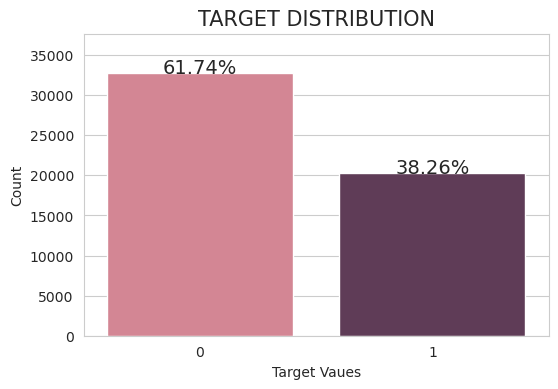

In [10]:
total = len(train_df)
plt.figure(dpi=100)

g = sns.countplot(x= 'label', data=train_df, palette=colors_nude)
g.set_title("TARGET DISTRIBUTION", fontsize = 15)
g.set_xlabel("Target Vaues", fontsize = 10)
g.set_ylabel("Count", fontsize = 10)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

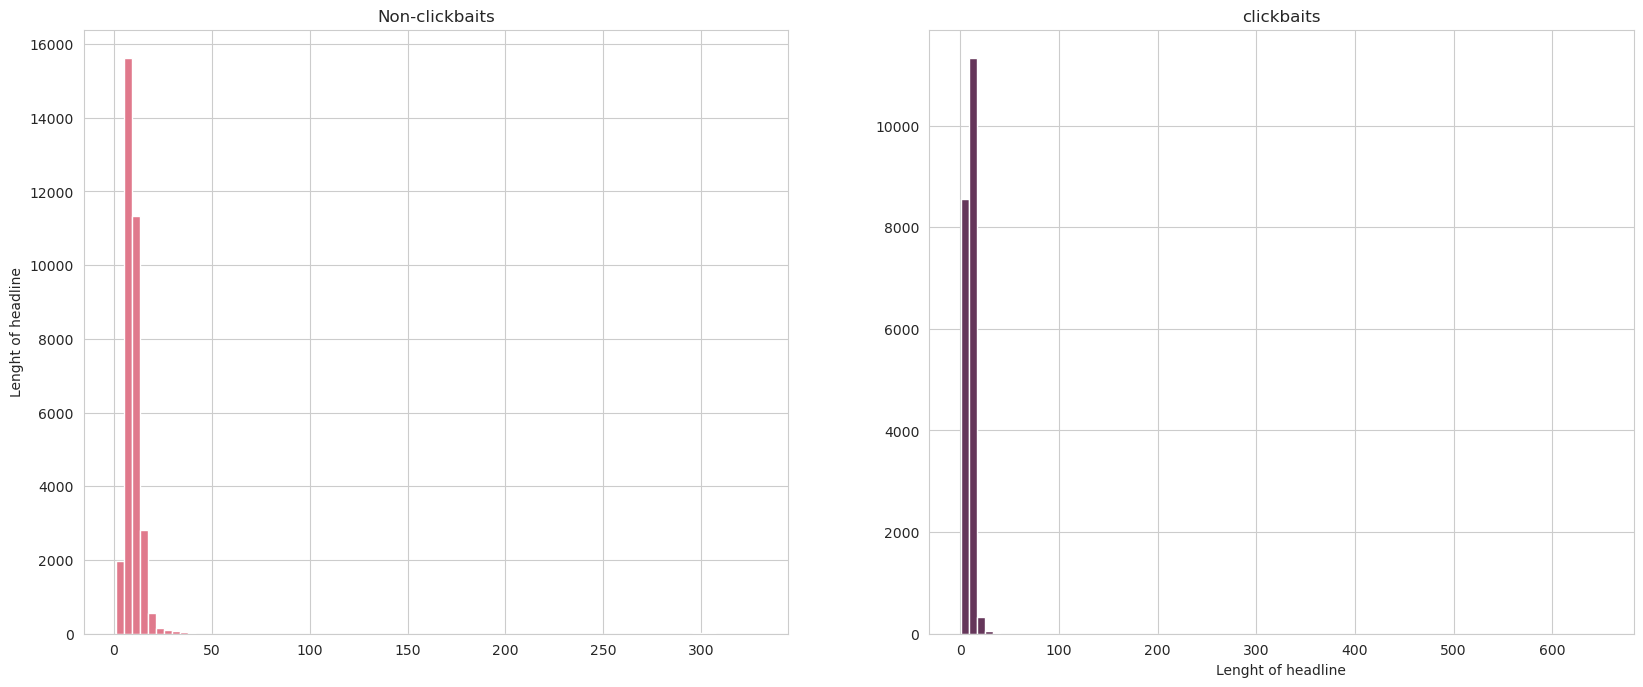

In [11]:
# Plot sentence lenght
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(20, 8), dpi=100)
num=train_df[train_df["label"]== 0]['headline'].str.split().map(lambda x: len(x))
ax1.hist(num,bins = 80,color=colors_nude[0])
ax1.set_title('Non-clickbaits')
ax1.set_ylabel('Lenght of headline')

num=train_df[train_df["label"]== 1]['headline'].str.split().map(lambda x: len(x))
ax2.hist(num,bins = 80, color=colors_nude[1])
ax2.set_title('clickbaits')
ax2.set_xlabel('Lenght of headline')

plt.show()

In [12]:
# Thanks to https://www.kaggle.com/httpwwwfszyc/bert-in-keras-taming
# Let check who many line is longer than MAX_LEN 
def convert_lines(example, max_seq_length, tokenizer):
    max_seq_length -= 2
    all_tokens = []
    longer = 0
    for text in tqdm(example):
        tokens_a = tokenizer.tokenize(text)
        if len(tokens_a) > max_seq_length:
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens_a + ["[SEP]"]) + [0] * (max_seq_length - len(tokens_a))
        all_tokens.append(one_token)
    print(f"There are only {longer} lines longer than {max_seq_length}")

    
convert_lines(train_df["headline"], config.MAX_LEN, config.TOKENIZER)

100%|██████████| 53029/53029 [00:11<00:00, 4775.47it/s]

There are only 69 lines longer than 126


**We can see in graph that most of the text lenght is less the 100  and only 65 line is longer than 256, so we can set our max length between 64 to 256.**

## 6. tSNE Embeddings
t-SNE stands for t-distributed stochastic neighbor embedding. It is a technique for dimensionality reduction that is best suited for the visualization of high dimensional data-set. t-SNE is a randomized algorithm, i;e every time we run the algorithm it returns slightly different results on the same data-set. To control this we set a random state with some arbitrary value. Random state is used here to seed the cost function of the algorithm.

In [13]:
tokenized = train_df["headline"].apply((lambda x: config.TOKENIZER.encode(x, max_length = config.MAX_LEN, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(padded).shape

(53029, 128)

[0.09188416 0.06866275]
 
PCA done! Time elapsed: 10.87325668334961 seconds


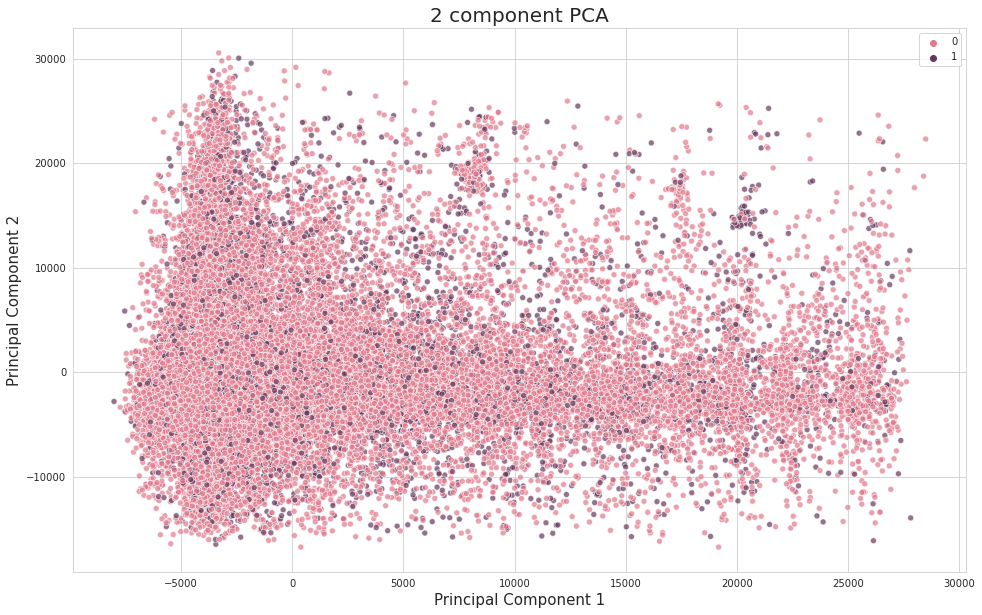

In [14]:
from cuml.manifold import TSNE
from cuml.decomposition import PCA
time_start = time.time()
pca = PCA(n_components=2)
pca_2D = pca.fit_transform(padded.astype(np.float32))
print(pca.explained_variance_ratio_)
print(' ')
print('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

pca_2D_one  = pca_2D[:,0]
pca_2D_two = pca_2D[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_2D_one, y=pca_2D_two,
    hue=train_df['label'].values,
    palette=sns.color_palette(colors_nude),
    legend="full",
    alpha=0.7
)
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
plt.show()

**By using the attribute explained_varianceratio, you can see that the first principal component contains 9.03% of the variance and the second principal component contains 6.75% of the variance. Together, the two components contain 9.03d% of the information. From graph we can say that text embeddings data not clearly have some clustering structure.**

**Let's now take a look at what TSNE can discern.**

t-SNE done! Time elapsed: 3.29410719871521 seconds


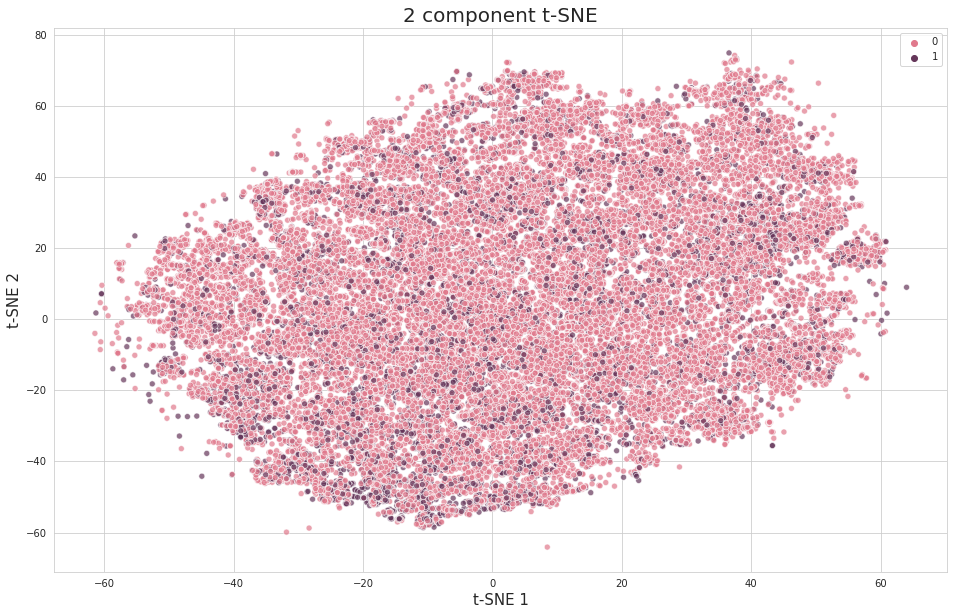

In [15]:
time_start = time.time()
tsne = TSNE(n_components=2)
tsne_2D = tsne.fit_transform(padded)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_2D_one  = tsne_2D[:,0]
tsne_2D_two = tsne_2D[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_2D_one, y=tsne_2D_two,
    hue=train_df['label'].values,
    palette=sns.color_palette(colors_nude),
    legend="full",
    alpha=0.7
)
plt.xlabel('t-SNE 1', fontsize = 15)
plt.ylabel('t-SNE 2', fontsize = 15)
plt.title('2 component t-SNE' ,fontsize = 20)
plt.show()

**This is already a significant improvement over the PCA visualisation we used earlier. We see that the text embeddings data definitley has some clustering structure. At first glance it doesn't seem that it's easy to clearly separate the target cases, partly becasue they comprise less than 2% of all the points. However, it seems like the most of them are concentrated in the center areas.**

In [16]:
class XLNETDataset:
    '''
    We are required to give it a number of pieces of information which seem redundant, 
    or like they could easily be inferred from the data without us explicity providing it.
    This class prepare the dataset or input format to XLNet modeling.
    '''
    def __init__(self, text, target):
        self.text = text
        self.target = target
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,                            # sentence to encode
            None,
            add_special_tokens=True,         # add '[CLS]' and '[SEP]'
            max_length=self.max_len,         # pad & truncate all sentences.
            pad_to_max_length=True,
        )
        
         # Map the tokens to thier word ids, mask and attention_mask
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
         # Return pytorch tensors
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(self.target[item], dtype=torch.float),
        }

In [17]:

class XLNETBaseCased(nn.Module):
        '''
        We'll be using XLNet Model. This class we feed the bert input data, the entire pre-trained 
        XLNet model and the additional untrained classification layer is trained on our specific task.
        '''
        def __init__(self):
            super(XLNETBaseCased, self).__init__()
            self.xlnet = transformers.XLNetModel.from_pretrained("xlnet-base-cased")
            self.xlnet_drop = nn.Dropout(0.25)    # define the dropout
            self.out = nn.Linear(768, 1)         # fully connected linear layer

        def forward(self, ids, mask, token_type_ids):
            # Perform a forward pass. Feeding the inputs in the XLNet model
            last_hidden_state = self.xlnet(
                ids, attention_mask=mask, token_type_ids=token_type_ids
            )
            # last hidden layer 
            last_hidden_state = last_hidden_state[0]
            # pool the outputs into a mean vector
            mean_last_hidden_state = torch.mean(last_hidden_state, 1)
            # performing dropout on  output vector
            xo = self.xlnet_drop(mean_last_hidden_state)
            # performing fully connected linear layer on output vector
            output = self.out(xo)                        
            return output

In [18]:
import time
import datetime
t0 = time.time() 
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# define the binary_cross_entropy loss function
def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))

# define the trainging function
def train_fn(data_loader, model, optimizer, device, scheduler):
    print("")
    print('Training...')
    # Set the model to training mode
    model.train()
    
    # trange is a tqdm wrapper around the normal python range
    for bi, d in enumerate(data_loader):
        # Unpack training batch from our dataloader.
        ids = d["ids"]
        mask = d["mask"]
        token_type_ids = d["token_type_ids"]
        targets = d["targets"]
        
        # copy each tensor to the GPU
        ids = ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)
        
        # clear any previously calculated gradients
        optimizer.zero_grad()
        
        # outputs prior to activation.
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)

        loss = loss_fn(outputs, targets)    # Perform a loss funtion
        if bi % 200 == 0 and not bi == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  Training Loss  {:>5,}.    Elapsed: {:}.'.format(bi, loss, elapsed))
            
        loss.backward()                     # Perform a backward pass to calculate the gradients
        if (bi+1) % config.ACCUM_STEPS == 0:  # Wait for several backward steps
            optimizer.step()                  # Update parameters
            scheduler.step()                  # Update the learning rate
        

        
# define the validation function        
def eval_fn(data_loader, model, device):
    print("")
    print("Running Validation...")
    model.eval()            # Set the model to training mode
    fin_targets = []        # target variable
    fin_outputs = []        # ouput variable
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
        # trange is a tqdm wrapper around the normal python range
        for bi, d in enumerate(data_loader):
            # Unpack validation batch from our dataloader.
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]
            
            # copy each tensor to the GPU
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)
            
            # outputs prior to activation.
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)        # Perform a loss funtion
            if bi % 100 == 0 and not bi == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
            
                # Report progress.
                print('  Batch {:>5,}  Valid Loss  {:>5,}.    Elapsed: {:}.'.format(bi, loss, elapsed))
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [19]:
print('Loading XLNet Model...')
device = torch.device("cuda")     # define the device
model = XLNETBaseCased()         # define the model
model.to(device)                # copy the model to the gpu

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Loading XLNet Model...



The BERT model has 208 different named parameters.

==== Embedding Layer ====

xlnet.mask_emb                                           (1, 1, 768)
xlnet.word_embedding.weight                             (32000, 768)
xlnet.layer.0.rel_attn.q                                (768, 12, 64)
xlnet.layer.0.rel_attn.k                                (768, 12, 64)
xlnet.layer.0.rel_attn.v                                (768, 12, 64)

==== First Transformer ====

xlnet.layer.0.rel_attn.o                                (768, 12, 64)
xlnet.layer.0.rel_attn.r                                (768, 12, 64)
xlnet.layer.0.rel_attn.r_r_bias                             (12, 64)
xlnet.layer.0.rel_attn.r_s_bias                             (12, 64)
xlnet.layer.0.rel_attn.r_w_bias                             (12, 64)
xlnet.layer.0.rel_attn.seg_embed                         (2, 12, 64)
xlnet.layer.0.rel_attn.layer_norm.weight                      (768,)
xlnet.layer.0.rel_attn.layer_norm.bias                   

In [20]:
# split up our traing set to use 90% for training and 10% for validation
df_train, df_valid = model_selection.train_test_split(
            train_df, test_size=0.1, random_state=101, stratify=train_df.label.values
        )
        
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

with timer('Training and Validation'):
    
    def run():
        seed_everything(config.SEED)
        
        # pass the sentence and target from training dataset into class
        train_dataset = XLNETDataset(
            text=df_train.headline.values, target=df_train.label.values
        )
        
        # Combine the training inputs into a TensorDataset.
        train_data_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=config.TRAIN_BATCH_SIZE, num_workers=4
        )
        
        # pass the sentence and target from training dataset into class
        valid_dataset = XLNETDataset(
            text=df_valid.headline.values, target=df_valid.label.values
        )
        
        # Combine the training inputs into a TensorDataset.
        valid_data_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1
        )
        
        # Prepare optimizer and schedule (linear warmup and decay)
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.01,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        
         # Create the numer of training steps, optimizer and scheduler
        num_train_steps = int(config.EPOCHS * len(train_dataset) / config.TRAIN_BATCH_SIZE / config.ACCUM_STEPS)
        optimizer = AdamW(optimizer_parameters, lr= config.LRATE)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=config.WARMUP, num_training_steps=num_train_steps
        )
        
        # running the loop for every epochs
        # Tracking variables 
        best_f1_score = 0
        for epoch in range(config.EPOCHS):
            print('======== Epoch {:} / {:} ========'.format(epoch + 1, config.EPOCHS))
            # passing training and validation funtion
            train_fn(train_data_loader, model, optimizer, device, scheduler)
            outputs, targets = eval_fn(valid_data_loader, model, device)
            outputs = np.array(outputs) >= 0.5
        
            # Calculate the validation accuracy for test sentences
            f1_score = metrics.f1_score(targets, outputs)
            
            # Report the final accuracy for this validation run.
            print("")
            print(f"Validation F1 Score = {f1_score}")
                        
            # saving the model
            if f1_score > best_f1_score:
                torch.save(model.state_dict(), config.MODEL_PATH)
                best_f1_score = f1_score


    if __name__ == "__main__":
        run()

======== Epoch 1 / 3 ========

Training...
  Batch   200  Training Loss  0.41423994302749634.    Elapsed: 0:02:22.
  Batch   400  Training Loss  0.18475134670734406.    Elapsed: 0:04:23.
  Batch   600  Training Loss  0.3528715968132019.    Elapsed: 0:06:24.
  Batch   800  Training Loss  0.12736524641513824.    Elapsed: 0:08:25.
  Batch 1,000  Training Loss  0.1988442987203598.    Elapsed: 0:10:26.
  Batch 1,200  Training Loss  0.19867202639579773.    Elapsed: 0:12:27.

Running Validation...
  Batch   100  Valid Loss  0.13340650498867035.    Elapsed: 0:13:55.
  Batch   200  Valid Loss  0.12395412474870682.    Elapsed: 0:14:07.

Validation F1 Score = 0.8507543103448276
======== Epoch 2 / 3 ========

Training...
  Batch   200  Training Loss  0.2808937728404999.    Elapsed: 0:16:20.
  Batch   400  Training Loss  0.17900975048542023.    Elapsed: 0:18:21.
  Batch   600  Training Loss  0.27615776658058167.    Elapsed: 0:20:23.
  Batch   800  Training Loss  0.09055594354867935.    Elapsed: 0:2

## Inference

In [21]:
# Setting up Device and Loading Models
DEVICE = 'cuda'
MODEL = XLNETBaseCased()
MODEL.load_state_dict(torch.load("./model.bin"))
MODEL.to(DEVICE)
MODEL.eval()

XLNETBaseCased(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [22]:
# pass the sentence and target from training dataset into class
valid_dataset = XLNETDataset(
    text=df_valid.headline.values, target=df_valid.label.values
)

# Combine the training inputs into a TensorDataset.
valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=config.VALID_BATCH_SIZE, num_workers=1
)


In [23]:
# Tell pytorch not to bother with constructing the compute graph during
# the forward pass, since this is only needed for backprop (training).
with torch.no_grad():
    fin_outputs = []
    for bi, d in tqdm(enumerate(valid_data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)

        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        outputs_np = outputs.cpu().detach().numpy().tolist()
        fin_outputs.extend(outputs_np)

295it [00:34,  8.56it/s]


In [24]:
# prediction
df_valid['prediction'] = (np.array(fin_outputs))
df_valid['prediction'] = (df_valid['prediction'] > 0.5).astype(np.uint)

In [25]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(df_valid.label.values, df_valid.prediction.values))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93      3274
           1       0.92      0.82      0.87      2029

    accuracy                           0.90      5303
   macro avg       0.91      0.89      0.90      5303
weighted avg       0.91      0.90      0.90      5303



In [26]:
# creating a function will take sentence and make the prediction
# It will return the probalility of the clickbait detection
def sentence_prediction(sentence):
    tokenizer = config.TOKENIZER
    max_len = config.MAX_LEN
    title = str(sentence)
    title = " ".join(title.split())

    inputs = tokenizer.encode_plus(
        title,
        None,
        add_special_tokens=True,
        max_length=max_len,
        pad_to_max_length=True,
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs['token_type_ids']

    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)

    ids = ids.to(DEVICE, dtype=torch.long)
    mask = mask.to(DEVICE, dtype=torch.long)
    token_type_ids = token_type_ids.to(DEVICE, dtype=torch.long)

    outputs = MODEL(ids=ids, mask=mask, token_type_ids=token_type_ids)

    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

#### Probalility of the Clickbait 

In [27]:
sentence_prediction("Man tries to hug a wild lion! You won't belive what happens next")

0.85801256

In [28]:
sentence_prediction("Britain says the drug has been approved for use in the state-run health service, and export restrictions have been introduced")

0.0063462546

In [29]:
sentence_prediction("Earn 50,000 dollar with this sample trick")

0.8936625